# LastFM Recommendation System - EDA
June [x] 2018  

### Import files and packages

In [1]:
# check kernel (optional)
import sys
sys.executable

'/home/cipher000/anaconda3/envs/ipykernel_py3/bin/python'

In [2]:
# First we import our packages needed for this analysis
import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix # compressed Sparse Row matrix
from sklearn.neighbors import NearestNeighbors # use K-Nearest Neighbors to find cosine distance amongst our artists
from fuzzywuzzy import fuzz # fuzzy string matching so we allow for slight misspellings of artist names

# for EDA
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
# Six csv files were provided, but we will only need two for our basic recommender system

# using artists and play count per user
artists = pd.read_csv('../data/artists.dat', sep='\t',usecols=['id','name'])
plays = pd.read_csv('../data/user_artists.dat', sep='\t')

# additional user data,for later analysis
tags = pd.read_csv('../data/tags.dat', sep='\t',encoding='latin-1')
friends = pd.read_csv('../data/user_friends.dat', sep='\t')
utat = pd.read_csv('../data/user_taggedartists-timestamps.dat', sep="\t")
uta = pd.read_csv('../data/user_taggedartists.dat', sep='\t')

In [4]:
play = pd.read_pickle('../data/recsys_plays.pkl')
tag = pd.read_pickle('../data/recsys_tags.pkl')
friend = pd.read_pickle('../data/recsys_friends.pkl')

In [5]:
tag.head()

,userID,artistID,tagID,timestamp,day,month,year,tagValue,name
0,2,52,13,1238536800000,1,4,2009,chillout,Morcheeba
1,2,52,15,1238536800000,1,4,2009,downtempo,Morcheeba
2,2,52,18,1238536800000,1,4,2009,electronic,Morcheeba
3,2,52,21,1238536800000,1,4,2009,trip-hop,Morcheeba
4,2,52,41,1238536800000,1,4,2009,female vovalists,Morcheeba


In [6]:
# sets output to three decimals
pd.set_option('display.float_format',lambda x: '%.3f' %x)

### Exploratory Data Analysis (EDA)

Analyze by:
- Timestamp
- Users
- Friends
- Tags
- Artists

Key features include:
- userID
- friendID
- artistID, Name
- weight (plays by user of artist)
- tagID, tagValue

Temporal:
- timestamp
- day, month, year

In [7]:
# Explore specs of each file provided.  We will only use artists and plays in the basic system.
csv_list = [artists, plays, tags, friends, utat,uta]
csv_names = ['artists', 'plays', 'tags', 'friends', 'user_taggedartists-timestamps','user_taggedartists']
for i in range(len(csv_list)):
    name = csv_names[i]
    shape = csv_list[i].shape
    columns = csv_list[i].columns
    unique = csv_list[i].nunique()
    print("{}\n{}\n{}\n{}\n".format(name, shape, columns,unique))

artists
(17632, 2)
Index(['id', 'name'], dtype='object')
id      17632
name    17632
dtype: int64

plays
(92834, 3)
Index(['userID', 'artistID', 'weight'], dtype='object')
userID       1892
artistID    17632
weight       5436
dtype: int64

tags
(11946, 2)
Index(['tagID', 'tagValue'], dtype='object')
tagID       11946
tagValue    11946
dtype: int64

friends
(25434, 2)
Index(['userID', 'friendID'], dtype='object')
userID      1892
friendID    1892
dtype: int64

user_taggedartists-timestamps
(186479, 4)
Index(['userID', 'artistID', 'tagID', 'timestamp'], dtype='object')
userID        1892
artistID     12523
tagID         9749
timestamp     3549
dtype: int64

user_taggedartists
(186479, 6)
Index(['userID', 'artistID', 'tagID', 'day', 'month', 'year'], dtype='object')
userID       1892
artistID    12523
tagID        9749
day             4
month          12
year           10
dtype: int64



### Artists + Plays

In [8]:
# Obtain total plays by artist
ap2 = (play.groupby(['name'])['weight'].sum().reset_index().
                rename(columns={'weight':'total_artist_plays','name':'artist_name'})
               [['artist_name','total_artist_plays']])

In [9]:
# merge artist and play files
artist_plays = pd.merge(artists, plays,how='left',left_on='id',right_on='artistID')

In [10]:
artist_plays.head()

,id,name,userID,artistID,weight
0,1,MALICE MIZER,34,1,212
1,1,MALICE MIZER,274,1,483
2,1,MALICE MIZER,785,1,76
3,2,Diary of Dreams,135,2,1021
4,2,Diary of Dreams,257,2,152


In [11]:
ap3 = ap2.sort_values(['total_artist_plays'],ascending=False)[:20]

In [12]:
ap3

,artist_name,total_artist_plays
2336,Britney Spears,2393140
3998,Depeche Mode,1301308
8352,Lady Gaga,1291387
3023,Christina Aguilera,1058405
11069,Paramore,963449
9130,Madonna,921198
12072,Rihanna,905423
12818,Shakira,688529
14109,The Beatles,662116
7913,Katy Perry,532545


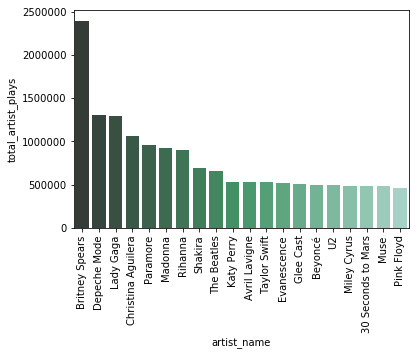

In [13]:
x = ap3.artist_name
y = ap3.total_artist_plays

sns.barplot(x, y, palette="BuGn_d")
plt.xticks(rotation=90)
plt.show()

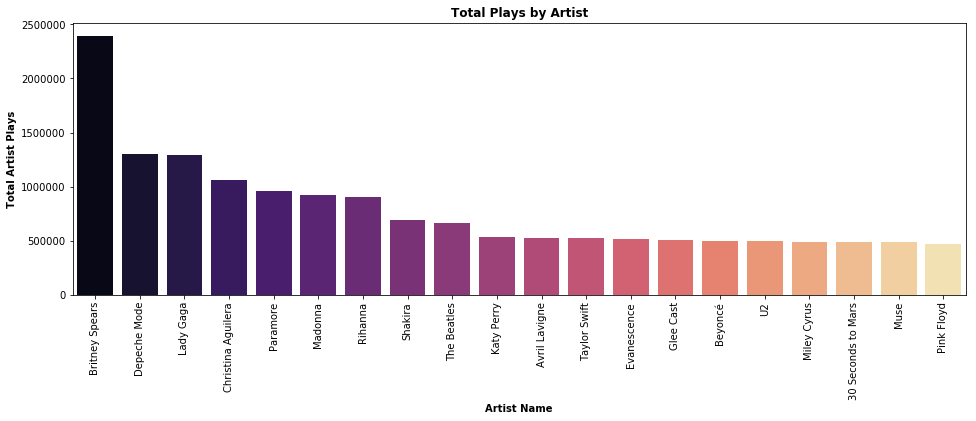

In [14]:
x = ap3.artist_name
y = ap3.total_artist_plays

fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
ax = sns.barplot(x, y, palette="magma")
ax.set_xlabel("Artist Name",fontweight='bold')
ax.set_ylabel("Total Artist Plays",fontweight='bold')
ax.set_title('Total Plays by Artist',fontweight='bold')
plt.xticks(rotation=90)
plt.show()

In [15]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [go.Bar(
            x = ap3.artist_name,
            y = ap3.total_artist_plays
    )]

py.iplot(data, filename='basic-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~cipher813/0 or inside your plot.ly account where it is named 'basic-bar'


### User Data

In [16]:
tag.head()

,userID,artistID,tagID,timestamp,day,month,year,tagValue,name
0,2,52,13,1238536800000,1,4,2009,chillout,Morcheeba
1,2,52,15,1238536800000,1,4,2009,downtempo,Morcheeba
2,2,52,18,1238536800000,1,4,2009,electronic,Morcheeba
3,2,52,21,1238536800000,1,4,2009,trip-hop,Morcheeba
4,2,52,41,1238536800000,1,4,2009,female vovalists,Morcheeba


In [17]:
tag2 = tag.groupby(['tagValue']).count().reset_index()[['tagID','tagValue']]

In [18]:
tag2.head()

,tagID,tagValue
0,4,'80s
1,3,-pearl fashion music
2,40,0 play yet
3,1,00
4,37,00's


In [19]:
tag2

,tagID,tagValue
0,4,'80s
1,3,-pearl fashion music
2,40,0 play yet
3,1,00
4,37,00's
5,1,007
6,808,00s
7,1,00s rock
8,2,1
9,42,1008


In [20]:
tag2

,tagID,tagValue
0,4,'80s
1,3,-pearl fashion music
2,40,0 play yet
3,1,00
4,37,00's
5,1,007
6,808,00s
7,1,00s rock
8,2,1
9,42,1008


In [21]:
tag2.shape

(9749, 2)

In [22]:
tag2.tagID.sum()

186479

In [23]:
tag3 = tag2.sort_values(['tagID'],ascending=False)[:20]

In [24]:
tag3

,tagID,tagValue
7473,7503,rock
6802,5418,pop
441,5251,alternative
2709,4672,electronic
4393,4458,indie
3099,4228,female vocalists
174,2791,80s
2120,2739,dance
457,2631,alternative rock
1834,2287,classic rock


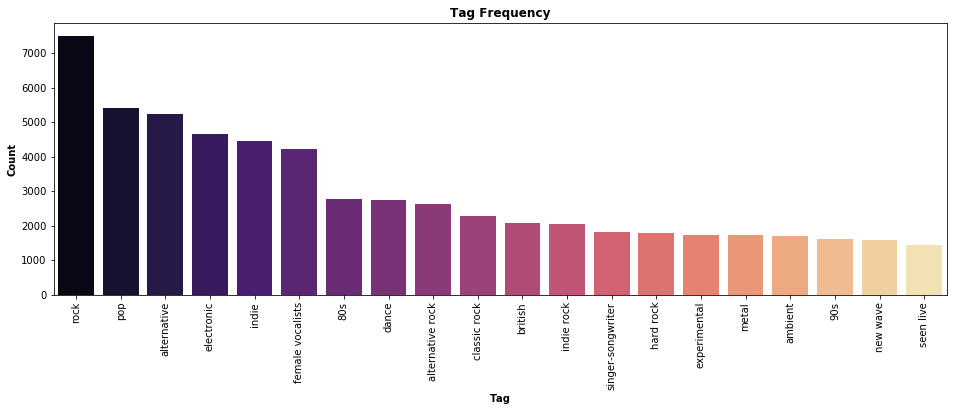

In [25]:
x = tag3.tagValue
y = tag3.tagID

fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
ax = sns.barplot(x, y, palette="magma")
ax.set_xlabel("Tag",fontweight='bold')
ax.set_ylabel("Count",fontweight='bold')
ax.set_title('Tag Frequency',fontweight='bold')
plt.xticks(rotation=90)
plt.show()

In [28]:
tags_per_artist = tag.groupby(['name']).count().reset_index()[['name','tagID']]
tpa2 = tags_per_artist.sort_values(['tagID'],ascending=False)[:20]

In [29]:
# Britney Spears is also the most tagged artist
tpa2.head()

,name,tagID
1637,Britney Spears,931
5770,Lady Gaga,767
2113,Christina Aguilera,762
6312,Madonna,730
2781,Depeche Mode,701


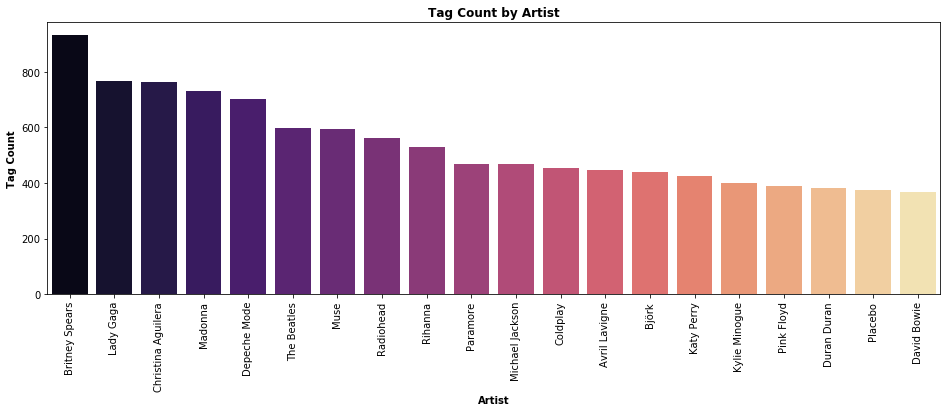

In [30]:
x = tpa2.name
y = tpa2.tagID

fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
ax = sns.barplot(x, y, palette="magma")
ax.set_xlabel("Artist",fontweight='bold')
ax.set_ylabel("Tag Count",fontweight='bold')
ax.set_title('Tag Count by Artist',fontweight='bold')
plt.xticks(rotation=90)
plt.show()

In [31]:
bs_tags = tag[tag['name']=='Britney Spears'].groupby(['tagValue']).count().reset_index()[['tagID','tagValue']]
bs2 = bs_tags.sort_values(['tagID'],ascending=False)[:20]

In [32]:
bs2

,tagID,tagValue
231,108,pop
90,64,dance
127,50,female vocalists
177,45,legend
68,37,britney spears
274,21,sexy
106,21,electronic
12,16,90s
23,13,amazing
26,13,american


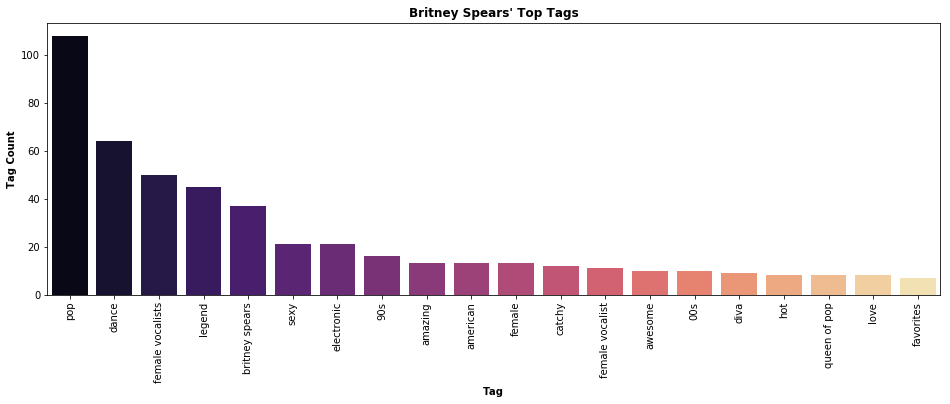

In [33]:
x = bs2.tagValue
y = bs2.tagID

fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
ax = sns.barplot(x, y, palette="magma")
ax.set_xlabel("Tag",fontweight='bold')
ax.set_ylabel("Tag Count",fontweight='bold')
ax.set_title('Britney Spears\' Top Tags',fontweight='bold')
plt.xticks(rotation=90)
plt.show()

In [38]:
play2 = play.groupby(['name']).count().reset_index()[['name','ever_played']]
play3 = play2.sort_values(['ever_played'],ascending=False)[:20]

In [39]:
play3

,name,ever_played
8352,Lady Gaga,611
2336,Britney Spears,522
12072,Rihanna,484
14109,The Beatles,480
7913,Katy Perry,473
9130,Madonna,429
1411,Avril Lavigne,417
3023,Christina Aguilera,407
10158,Muse,400
11069,Paramore,399


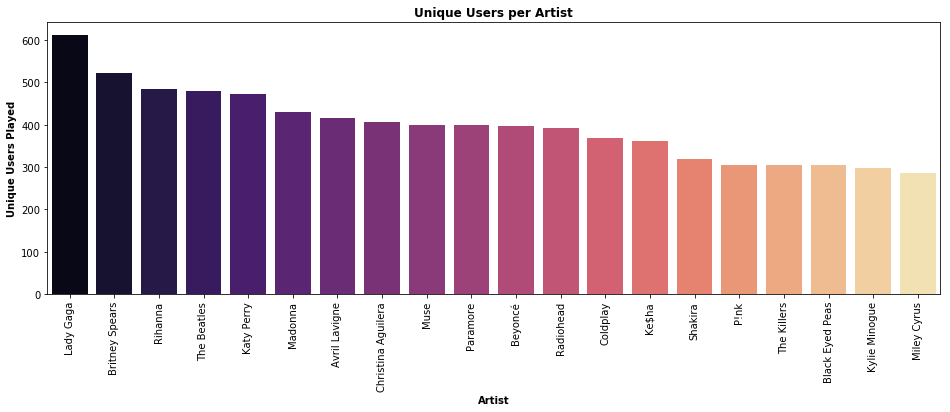

In [40]:
x = play3.name
y = play3.ever_played

fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
ax = sns.barplot(x, y, palette="magma")
ax.set_xlabel("Artist",fontweight='bold')
ax.set_ylabel("Unique Users Played",fontweight='bold')
ax.set_title('Unique Users per Artist',fontweight='bold')
plt.xticks(rotation=90)
plt.show()

In [46]:
# plays per user
ppu = pd.merge(play2,ap2,how='outer',left_on='name',right_on='artist_name')

In [47]:
ppu

,name,ever_played,artist_name,total_artist_plays
0,!!!,2,!!!,2826
1,!DISTAIN,2,!DISTAIN,1257
2,!deladap,1,!deladap,65
3,#####,8,#####,3707
4,#2 Orchestra,1,#2 Orchestra,144
5,$lick,1,$lick,1395
6,$lick feat. Six-Fo,1,$lick feat. Six-Fo,72
7,(1962-1966),1,(1962-1966),58
8,(Pre) Kingdom,1,(Pre) Kingdom,1
9,(We Are) Performance,1,(We Are) Performance,1


In [48]:
ppu['plays_per_user'] = ppu['total_artist_plays']/ppu['ever_played']

In [49]:
ppu

,name,ever_played,artist_name,total_artist_plays,plays_per_user
0,!!!,2,!!!,2826,1413.000
1,!DISTAIN,2,!DISTAIN,1257,628.500
2,!deladap,1,!deladap,65,65.000
3,#####,8,#####,3707,463.375
4,#2 Orchestra,1,#2 Orchestra,144,144.000
5,$lick,1,$lick,1395,1395.000
6,$lick feat. Six-Fo,1,$lick feat. Six-Fo,72,72.000
7,(1962-1966),1,(1962-1966),58,58.000
8,(Pre) Kingdom,1,(Pre) Kingdom,1,1.000
9,(We Are) Performance,1,(We Are) Performance,1,1.000


In [55]:
ppu2 = ppu.sort_values(['total_artist_plays'],ascending=False)[:20]

In [56]:
ppu2.head()

,name,ever_played,artist_name,total_artist_plays,plays_per_user
2336,Britney Spears,522,Britney Spears,2393140,4584.559
3998,Depeche Mode,282,Depeche Mode,1301308,4614.567
8352,Lady Gaga,611,Lady Gaga,1291387,2113.563
3023,Christina Aguilera,407,Christina Aguilera,1058405,2600.504
11069,Paramore,399,Paramore,963449,2414.659


In [57]:
play[(play['name']=='Britney Spears') & (play['weight']>0)].count()

name           522
userID         522
artistID       522
weight         522
ever_played    522
dtype: int64

In [58]:
play[(play['name']=='Britney Spears') & (play['weight']>0)].sum()

name           Britney SpearsBritney SpearsBritney SpearsBrit...
userID                                                    536585
artistID                                                  150858
weight                                                   2393140
ever_played                                                  522
dtype: object

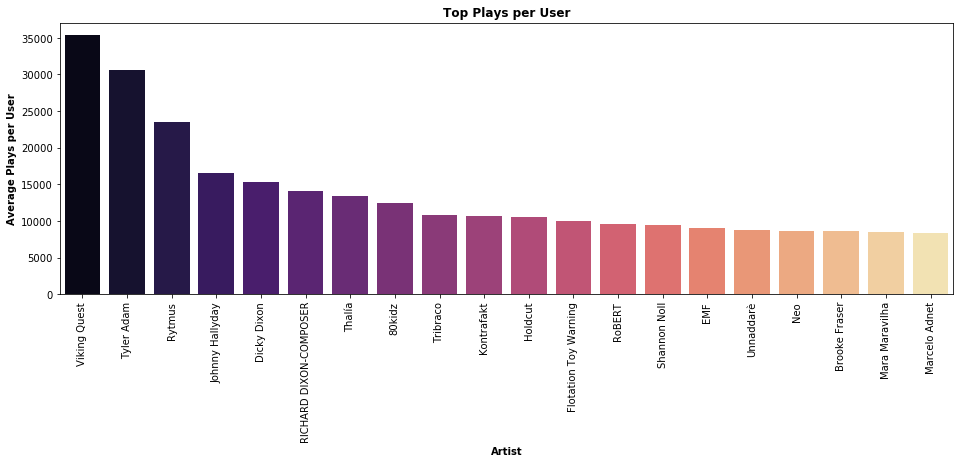

In [54]:
x = ppu2.name
y = ppu2.plays_per_user

fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
ax = sns.barplot(x, y, palette="magma")
ax.set_xlabel("Artist",fontweight='bold')
ax.set_ylabel("Average Plays per User",fontweight='bold')
ax.set_title('Top Plays per User',fontweight='bold')
plt.xticks(rotation=90)
plt.show()

In [ ]:
ud1 = pd.merge(utat,uta,how='outer') # ud = user data
assert len(ud1) == len(uta) == len(utat)

In [ ]:
ud1.head()

In [ ]:
friends.head()

In [ ]:
friends[friends['userID']==3]

In [ ]:
friends.describe()

In [ ]:
import networkx as nx

In [ ]:
len(friends.userID)

In [ ]:
G = nx.Graph()
G.add_nodes_from(friends.userID)

In [ ]:
for i in range(len(friends)):
    G.add_edge(friends.userID.iloc[i],friends.friendID.iloc[i])


In [ ]:
G.number_of_nodes()

In [ ]:
G.number_of_edges()

In [ ]:
import igraph as ig

In [ ]:
Edges=[(friends.userID.iloc[i],friends.friendID.iloc[i]) for i in range(len(friends))]
Nodes=[(friends.userID.iloc[i],1) for i in range(len(friends))]

In [ ]:
labels = []
group = []
for node in Nodes:
    labels.append(node[0])
    group.append(node[1])

In [ ]:
G=ig.Graph(Edges,directed=False)

In [ ]:
layt=G.layout('kk',dim=3)

In [ ]:
layt[5]

In [ ]:
N = len(layt)
Xn = [layt[k][0] for k in range(N)]
Yn = [layt[k][1] for k in range(N)]
Zn = [layt[k][2] for k in range(N)]
Xe = []
Ye = []
Ze = []

for e in Edges:
    Xe+=[layt[e[0]][0], layt[e[1]][0],None]
    Ye+=[layt[e[0]][1], layt[e[1]][1],None]
    Ze+=[layt[e[0]][2], layt[e[1]][2],None]

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go

In [ ]:
trace1=go.Scatter3d(x=Xe,y=Ye,z=Ze,
                    mode='lines',
                    line=dict(color='rgb(125,125,125)',width=1),
                   hoverinfo='none')
trace2=go.Scatter3d(x=Xn,y=Yn,z=Zn,
                    mode='markers',
                    name='actors',
                    marker=dict(symbol='dot',
                                size=6,
                                color=group,
                                colorscale='Viridis',
                                line=dict(color='rgb(125,125,125)',width=0.5)),
                    text=labels,
                    hoverinfo='text')

In [ ]:
axis=dict(showbackground=False,
         showline=False,
         zeroline=False,
         showgrid=False,
         showticklabels=False,
         title='')

In [ ]:
layout = go.Layout(
            title='LastFM Friend Network',
            width=1000,
            height=1000,
            showlegend=False,
            scene=dict(xaxis=dict(axis),
                      yaxis=dict(axis),
                      zaxis=dict(axis),
                      ),
            margin=dict(t=100),
            hovermode='closest',
            annotations=[dict(showarrow=False,
                 text='Data Source: www.last.fm, courtesy of Lab41/GroupLens',
                 xref='paper',
                 yref='paper',
                 x=0,
                 y=0.1,
                 xanchor='left',
                 yanchor='bottom',
                 font=dict(size=14))],)

In [ ]:
data=[trace1,trace2]

In [ ]:
data

In [ ]:
fig=go.Figure(data=data,layout=layout)

py.iplot(fig,filename='LastFM Friend Network')